In [1]:
import os
from typing import Dict, List, Tuple
import json
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
import numpy as np
import fire

import torch
import torch.nn as nn

import sklearn.gaussian_process as gp

from bayesian_optimization import BayesianOptimization

from super_resolution import super_resolution
from denoising import denoising
from inpainting import inpainting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 11
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
trials = 10
minimize = True
num_iter_eval_fn = 10
criterion = 'nll'
metric = "psnr_gt"
img_name = "xray"
task = 'denoising'
config = "configs/bo_own"
save = False
save_trials = True
log_dir = "/media/fastdata/toelle/logs_del"
gpu = 1

In [3]:
with open(config + ".json") as f:
    config = json.load(f)

NET_SPECS = config["net_specs"]
OPTIM_SPECS = config["optim_specs"]

if task == "denoising":
    fn = denoising
elif task == "super_resolution":
    fn = super_resolution
elif task == "inpainting":
    fn = inpainting

In [4]:
def eval_fn(params: Dict[str, float]) -> Dict[str, Tuple[float]]:
    for p_name, p_val in params.items():
        if p_name in config["optim_params"]:
            OPTIM_SPECS[p_name] = p_val
        else:
            NET_SPECS[p_name] = p_val

    results = fn(img_name=img_name,
                 num_iter=num_iter_eval_fn,
                 criterion=criterion,
                 net_specs=NET_SPECS,
                 optim_specs=OPTIM_SPECS,
                 save=save_trials,
                 path_log_dir=log_dir,
                 gpu=gpu,
                 seed=seed) # torch.randint(1000, (1,)).item())

    res = results[metric][-int(0.1*num_iter_eval_fn):]
    return [np.mean(res)]

I: 10 | ELBO: 0.74 | PSNR_noisy: 11.95 | PSNR_gt: 12.61 | PSNR_gt_sm: 11.58: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


> /home/toelle/Dropbox/Projects/midl/denoising.py(153)denoising()
    151     if save:
    152         import pdb; pdb.set_trace()
--> 153         save_run(results, net, optimizer, net_input_saved, out_avg, sgld_imgs, path=path_log_dir)
    154 
    155     if __name__ != "__main__":



ipdb>  path_log_dir


'/media/fastdata/toelle/prior_mu_0.0_kl_type_forw_beta_1e-0_prior_sigma_0.07_xray_02_10_2021_11_05_58'


ipdb>  c


I: 10 | ELBO: 0.50 | PSNR_noisy: 12.04 | PSNR_gt: 12.71 | PSNR_gt_sm: 11.56: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


> /home/toelle/Dropbox/Projects/midl/denoising.py(153)denoising()
    151     if save:
    152         import pdb; pdb.set_trace()
--> 153         save_run(results, net, optimizer, net_input_saved, out_avg, sgld_imgs, path=path_log_dir)
    154 
    155     if __name__ != "__main__":



ipdb>  q


BdbQuit: 

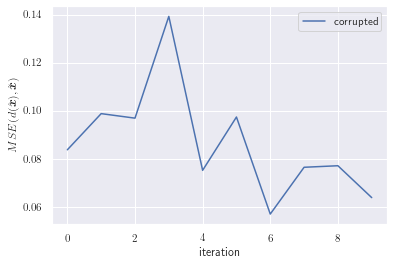

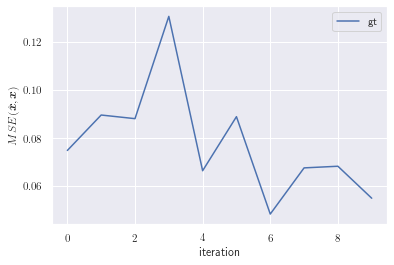

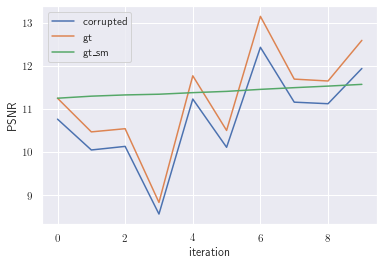

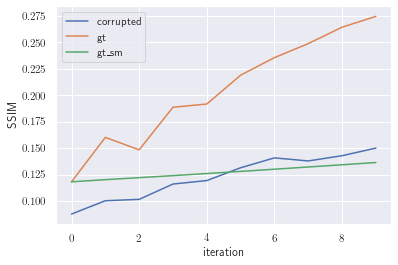

In [5]:
params = {p["name"]: p["bounds"] for p in config["parameter"]}

initial_params_vals = config["initial_parameter"] if "initial_parameter" in config.keys() else None

acq_kwargs = {"xi": 0.001}

bayesian_optimization = BayesianOptimization(
    params=params,
    initial_params_vals=initial_params_vals,
    n_init=2,
    obj_fn=eval_fn,
    acq_fn='expected_improvement',
    acq_kwargs=acq_kwargs
)

lengthscale_prior = dict(concentration=0.1, rate=1.5)
lengthscale_constraint = 0.05
mean_prior = dict(loc=25., scale=2.)
noise_prior = dict(concentration=1e-2, rate=100.)
#noise_prior = 1e-4

best_params = bayesian_optimization.optimize(trials=trials, plot=True, lengthscale_prior=lengthscale_prior, lengthscale_constraint=lengthscale_constraint, 
                                             mean_prior=mean_prior, noise_prior=noise_prior, num_iter_gp=1000)

print(best_params)